### Transfer Learning : Fine Tuning

### Creating Helper Functions

In [1]:
!wget https://raw.githubusercontent.com/ishan-0611/Deep-Learning/main/helper_functions.py

--2024-02-16 19:17:05--  https://raw.githubusercontent.com/ishan-0611/Deep-Learning/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-02-16 19:17:05 (77.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# Import helper functions to be used

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [3]:
# Getting 10% of the data , the previous dataset

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2024-02-16 19:17:12--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.207, 172.253.117.207, 142.250.99.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  98.8MB/s    in 1.6s    

2024-02-16 19:17:14 (98.8 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
# Creating the training and testing directories

train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [5]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                 image_size = IMG_SIZE,
                                                                 label_mode = "categorical",
                                                                 batch_size = BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                 image_size = IMG_SIZE,
                                                                 label_mode = "categorical",
                                                                 batch_size = BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [6]:
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

### Model 0 : Using Keras Functional API

In [7]:

# 1. Create the base model using tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top = False)


# 2. Freeze the base model(so that underlying pre-trained patterns are not updated)
base_model.trainable = False


# 3. Create inputs to our model
inputs = tf.keras.Input(shape = (224, 224, 3), name = "input_Layer")


# 4. If using ResNet50V2, Normalise the inputs
# x = tf.keras.experimental.preprocessing.Rescaling(1/255.0)(inputs)


# 5. Pass the input shapes to the base model (EffNetV2 need not be normalised)
x = base_model(inputs)

# Check the input shape just after passing
print(f"Shape after passing inputs to model is : {x.shape}")


# 6. Average Pool the outputs of the base model
# Inlcudes aggregation of useful info, reduce number of computations
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f"Shape after passing Global Pooling 2D : {x.shape}")


# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation = "softmax", name = "output_layer")(x)


# 8. Combine the inputs and outputs of the model
model_0 = tf.keras.Model(inputs, outputs)


# 9. Compile the model
model_0.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])


# 10. Fit the model and save its history
history_0 = model_0.fit(train_data,
                        epochs = 5,
                        steps_per_epoch = len(train_data),
                        validation_data = test_data,
                        validation_steps = int(0.25 * len(test_data)),
                        callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                experiment_name = "model_0")])

24274472/24274472 [==============================] - 0s 0us/step
Shape after passing inputs to model is : (None, 7, 7, 1280)
Shape after passing Global Pooling 2D : (None, 1280)
Saving TensorBoard log files to: transfer_learning/model_0/20240216-191726
Epoch 1/5
24/24 [==============================] - 18s 250ms/step - loss: 1.8704 - accuracy: 0.4080 - val_loss: 1.3100 - val_accuracy: 0.7155
Epoch 2/5
24/24 [==============================] - 4s 168ms/step - loss: 1.1543 - accuracy: 0.7467 - val_loss: 0.9244 - val_accuracy: 0.7944
Epoch 3/5
24/24 [==============================] - 6s 213ms/step - loss: 0.8378 - accuracy: 0.8387 - val_loss: 0.7480 - val_accuracy: 0.8224
Epoch 4/5
24/24 [==============================] - 4s 166ms/step - loss: 0.6926 - accuracy: 0.8547 - val_loss: 0.6329 - val_accuracy: 0.8536
Epoch 5/5
24/24 [==============================] - 3s 128ms/step - loss: 0.5923 - accuracy: 0.8840 - val_loss: 0.5782 - val_accuracy: 0.8470


In [8]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 7s 81ms/step - loss: 0.5797 - accuracy: 0.8528


[0.5797063708305359, 0.8528000116348267]

In [9]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_Layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
__________________

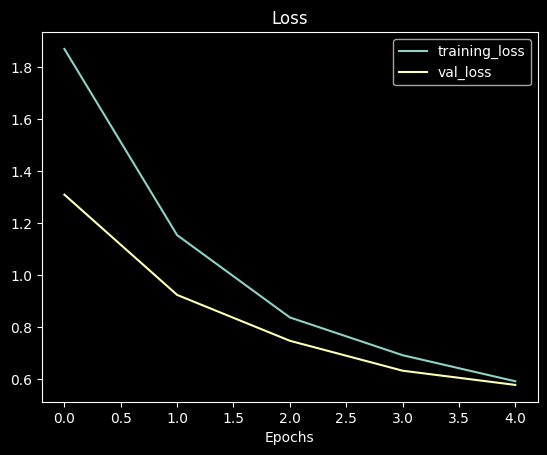

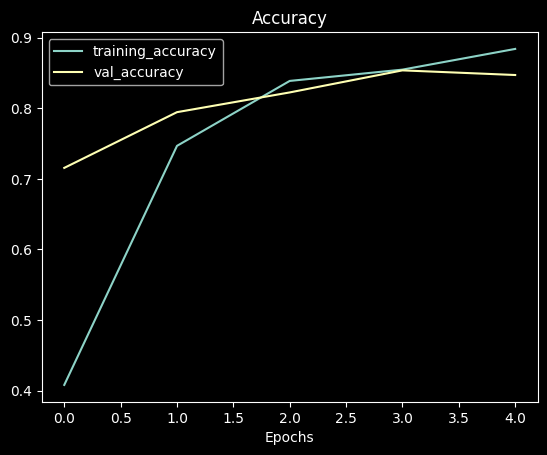

In [10]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

plot_loss_curves(history_0)

#### Getting a Feature Vector from our trained model

* 🔑 Note: One of the reasons feature extraction transfer learning is named how it is is because what often happens is a pretrained model outputs a feature vector (a long tensor of numbers, in our case, this is the output of the tf.keras.layers.GlobalAveragePooling2D() layer) which can then be used to extract patterns out of.



### Running a series of Transfer Learning Experiments

1. Model 1: Use feature extraction transfer learning on 1% of the training data with data augmentation.
2. Model 2: Use feature extraction transfer learning on 10% of the training data with data augmentation and save the results to a checkpoint.
3. Model 3: Fine-tune the Model 2 checkpoint on 10% of the training data with data augmentation.
4. Model 4: Fine-tune the Model 2 checkpoint on 100% of the training data with data augmentation.

While all of the experiments will be run on different versions of the training data, they will all be evaluated on the same test dataset, this ensures the results of each experiment are as comparable as possible.

In [11]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

--2024-02-16 19:18:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.207, 74.125.135.207, 173.194.202.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   151MB/s    in 0.8s    

2024-02-16 19:18:26 (151 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [12]:
unzip_data("10_food_classes_1_percent.zip")

In [13]:
train_data = "10_food_classes_1_percent/train"
test_data = "10_food_classes_1_percent/test"

In [14]:
IMG_SIZE = (224, 224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_data,
                                                                 label_mode = "categorical",
                                                                 image_size = IMG_SIZE,
                                                                 batch_size = 32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_data,
                                                                 label_mode = "categorical",
                                                                 image_size = IMG_SIZE,
                                                                 batch_size = 32)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


* Adding Data Augmentation into our model

In [15]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


# Create Data Augmentation stage with horizontal flipping, rotations , zoom etc.
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    # preprocessing.Rescale(1./255)
], name = "data_augmentation")

### Visualising our Data Augmentation Layer

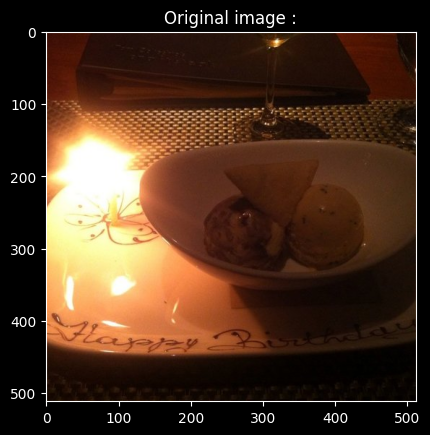

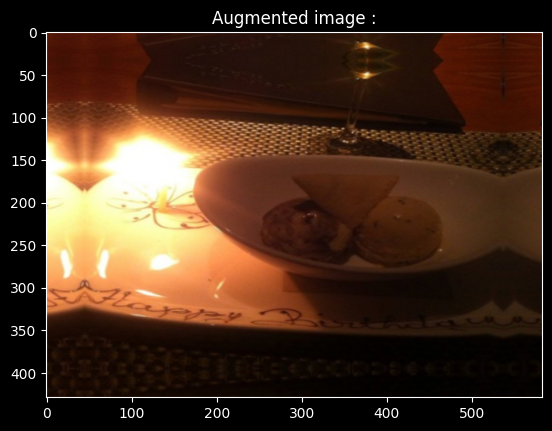

In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class

random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

img = mpimg.imread(random_image_path)
plt.title('Original image :')
plt.imshow(img);

augmented_img = data_augmentation(tf.expand_dims(img, axis = 0), training = True)
plt.figure()
plt.title('Augmented image :')
plt.imshow(tf.squeeze(augmented_img)/255.);

### Model 1 : Feature extraction transfer learning on 1% of the data with data augmentation

In [17]:
# Setup input shape and base model and freeze the base model
input_shape = (224, 224, 3)

base_model = tf.keras.applications.EfficientNetV2B0(include_top = False)
base_model.trainable = False

# Create input layer
inputs = tf.keras.layers.Input(shape = input_shape, name = "input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base model inputs(after augmentation) and don't train it
x = base_model(x, training = False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation = "softmax", name = "output_layer")(x)

# Make a model using inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                      epochs = 5,
                      steps_per_epoch = len(train_data),
                      validation_data = test_data,
                      validation_steps = int(0.25 * len(test_data)),
                      # Track model training logs
                      callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                               experiment_name = "model_1")])

Saving TensorBoard log files to: transfer_learning/model_1/20240216-191832
Epoch 1/5
3/3 [==============================] - 16s 3s/step - loss: 2.2875 - accuracy: 0.1286 - val_loss: 2.2006 - val_accuracy: 0.1743
Epoch 2/5
3/3 [==============================] - 6s 2s/step - loss: 2.0809 - accuracy: 0.2571 - val_loss: 2.0752 - val_accuracy: 0.2780
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.9566 - accuracy: 0.3286 - val_loss: 1.9831 - val_accuracy: 0.3339
Epoch 4/5
3/3 [==============================] - 6s 2s/step - loss: 1.7747 - accuracy: 0.4857 - val_loss: 1.9004 - val_accuracy: 0.4013
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 1.6290 - accuracy: 0.6143 - val_loss: 1.8195 - val_accuracy: 0.4589


In [18]:
results_1_data_aug = model_1.evaluate(test_data)
results_1_data_aug

79/79 [==============================] - 5s 58ms/step - loss: 1.8224 - accuracy: 0.4580


[1.8224326372146606, 0.4580000042915344]

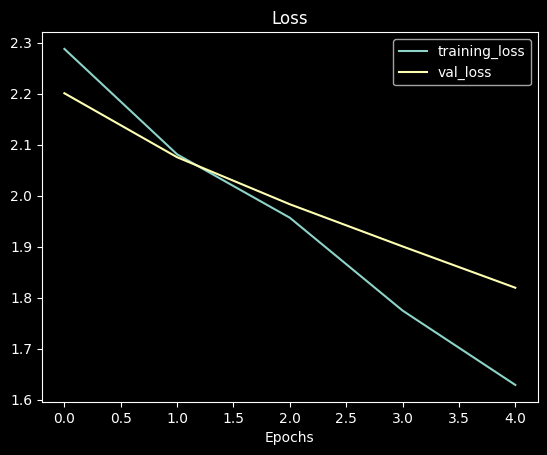

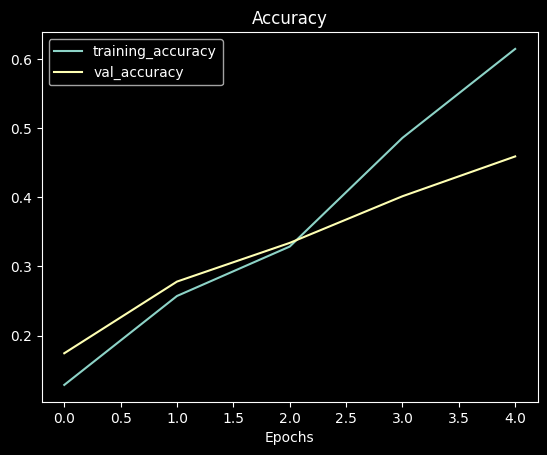

In [19]:
plot_loss_curves(history_1)

### Model 2 : Feature extraction transfer learning with 10% of data and data augmentation

In [20]:
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [21]:
# Set Data Inputs
IMG_SIZE = (224, 224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                 image_size = IMG_SIZE,
                                                                 label_mode = "categorical")

# Defualt Batch size is 32

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                image_size = IMG_SIZE,
                                                                label_mode = "categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [22]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Create model 2 with built in Data Augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
], name = "data_augmentation")


# Setup the input shape to our model
input_shape = (224, 224, 3)


# Create a frozen base model (also called as BackBone)
base_model = tf.keras.applications.EfficientNetV2B0(include_top = False)
base_model.trainable = False

# Create input and output layers(including the layers in between)
inputs = layers.Input(shape = input_shape, name = "input_layer")
x = data_augmentation(inputs)
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation = "softmax", name = "output_layer")(x)
model_2 = keras.Model(inputs, outputs)


# Compile the model
model_2.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])


### Creating a Model Checkpoint callback

* The ModelCheckpoint callback gives you the ability to save your model, as a whole in the SavedModel format or the weights (patterns) only to a specified directory as it trains.

* This is helpful if you think your model is going to be training for a long time and you want to make backups of it as it trains. It also means if you think your model could benefit from being trained for longer, you can reload it from a specific checkpoint and continue training from there.

* For example, say you fit a feature extraction transfer learning model for 5 epochs and you check the training curves and see it was still improving and you want to see if fine-tuning for another 5 epochs could help, you can load the checkpoint, unfreeze some (or all) of the base model layers and then continue training.

In [23]:
# Set checkpoint path
checkpoint_path = "10_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a model checkpoint that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         save_weights_only = True,
                                                         save_best_only = False,
                                                         save_freq = "epoch")

In [24]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5

history_2 = model_2.fit(train_data,
                        epochs = initial_epochs,
                        validation_data = test_data,
                        validation_steps = int(0.25 * len(test_data)),
                        callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                 experiment_name = "model_2"),
                                                                 checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/model_2/20240216-191924
Epoch 1/5
24/24 [==============================] - 35s 1s/step - loss: 1.9548 - accuracy: 0.3880 - val_loss: 1.4568 - val_accuracy: 0.6859
Epoch 2/5
24/24 [==============================] - 27s 1s/step - loss: 1.3650 - accuracy: 0.6680 - val_loss: 1.0306 - val_accuracy: 0.7796
Epoch 3/5
24/24 [==============================] - 22s 906ms/step - loss: 1.0637 - accuracy: 0.7533 - val_loss: 0.8230 - val_accuracy: 0.7961
Epoch 4/5
24/24 [==============================] - 21s 838ms/step - loss: 0.9070 - accuracy: 0.7733 - val_loss: 0.7199 - val_accuracy: 0.8125
Epoch 5/5
24/24 [==============================] - 21s 868ms/step - loss: 0.8215 - accuracy: 0.8053 - val_loss: 0.6494 - val_accuracy: 0.8273


In [25]:
model_0.evaluate(test_data)

79/79 [==============================] - 5s 59ms/step - loss: 0.5797 - accuracy: 0.8528


[0.5797061324119568, 0.8528000116348267]

In [26]:
model_2.evaluate(test_data)

79/79 [==============================] - 6s 66ms/step - loss: 0.6517 - accuracy: 0.8336


[0.6517252326011658, 0.8335999846458435]

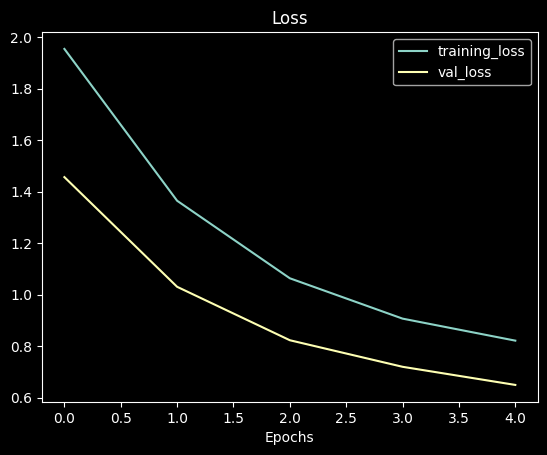

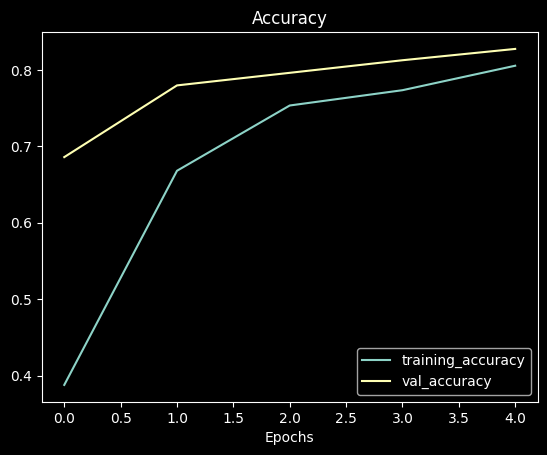

In [27]:
plot_loss_curves(history_2)

#### Loading in checkpointed weights

* To load saved model weights you can use the the load_weights() method, passing it the path where your saved weights are stored.

In [28]:
model_2.load_weights(checkpoint_path)

In [29]:
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 5s 58ms/step - loss: 0.6517 - accuracy: 0.8336


### Model 3 : Fine-tuning an existing model on 10% of the data

* Fine-tuning usually works best after training a feature extraction model for a few epochs and with large amounts of data. For more on this, check out Keras' guide on Transfer learning & fine-tuning.

In [30]:
model_2.layers

In [31]:
for layer in model_2.layers:
    print(layer, ': ', layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7c64f83e7640> :  True
<keras.src.engine.sequential.Sequential object at 0x7c64f82ad840> :  True
<keras.src.engine.functional.Functional object at 0x7c64f82695d0> :  False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7c650964b430> :  True
<keras.src.layers.core.dense.Dense object at 0x7c64f80dbb50> :  True


In [32]:
# To begin fine tuning, set last 10 layers.trainable = True
base_model.trainable = True

# Freeze all layers except the last 10
for layer in base_model.layers[:-10]:
     layer.trainable = False

# Recompile the model (we have to recompile everytime we make a change)
model_2.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
                metrics = ["accuracy"])

In [33]:
print(len(model_2.trainable_variables))

12


In [34]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 but with more trainable parameters)
history_fine_10_percent_data_aug = model_2.fit(train_data,
                                               epochs = fine_tune_epochs,
                                               validation_data = test_data,
                                               validation_steps = int(0.25 * len(test_data)),
                                               initial_epoch = history_2.epoch[-1],
                                               # Start training from previous last epoch
                                               callbacks = [create_tensorboard_callback(
                                                   dir_name = "transfer_learning",
                                                   experiment_name = "10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20240216-192253
Epoch 5/10
24/24 [==============================] - 32s 933ms/step - loss: 0.6764 - accuracy: 0.8013 - val_loss: 0.5385 - val_accuracy: 0.8224
Epoch 6/10
24/24 [==============================] - 21s 844ms/step - loss: 0.5805 - accuracy: 0.8133 - val_loss: 0.5058 - val_accuracy: 0.8257
Epoch 7/10
24/24 [==============================] - 19s 770ms/step - loss: 0.5532 - accuracy: 0.8107 - val_loss: 0.4729 - val_accuracy: 0.8289
Epoch 8/10
24/24 [==============================] - 17s 700ms/step - loss: 0.4621 - accuracy: 0.8587 - val_loss: 0.4929 - val_accuracy: 0.8273
Epoch 9/10
24/24 [==============================] - 18s 745ms/step - loss: 0.4713 - accuracy: 0.8533 - val_loss: 0.4485 - val_accuracy: 0.8470
Epoch 10/10
24/24 [==============================] - 16s 653ms/step - loss: 0.4139 - accuracy: 0.8773 - val_loss: 0.4823 - val_accuracy: 0.8405


In [35]:
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 5s 59ms/step - loss: 0.4459 - accuracy: 0.8528


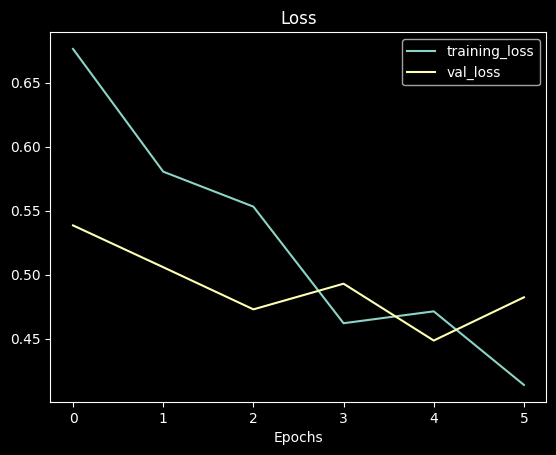

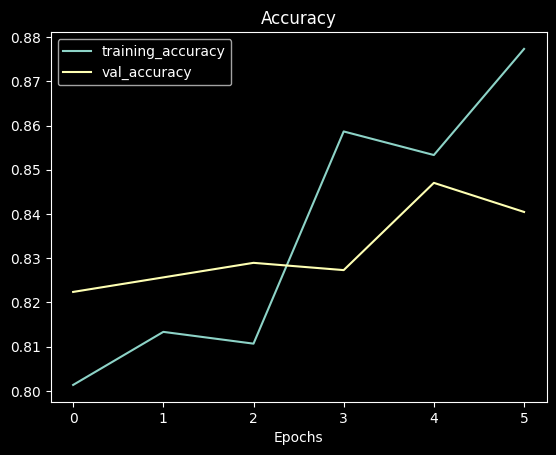

In [36]:
plot_loss_curves(history_fine_10_percent_data_aug)

* Alright, we need a way to evaluate our model's performance before and after fine-tuning. How about we write a function to compare the before and after?

In [37]:
# A function to compare history of model before and after fine tuning

def compare_history(original_history, new_history, initial_epochs = 5):
    """
    Compares 2 Tensorflow model history objects.
    """

    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize = (7, 5))
    plt.subplot(2, 1, 1)

    plt.plot(total_acc, label = "Training Accuracy")
    plt.plot(total_val_acc, label = "Validation Accuracy")

    plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label = 'Start Fine Tuning')
    plt.legend(loc = 'lower right')
    plt.title('Training and Validation Accuracy')


    # Make plots
    plt.figure(figsize = (7, 5))
    plt.subplot(2, 1, 1)

    plt.plot(total_loss, label = "Training Loss")
    plt.plot(total_val_loss, label = "Validation Loss")

    plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label = 'Start Fine Tuning')
    plt.legend(loc = 'upper right')
    plt.title('Training and Validation Loss')

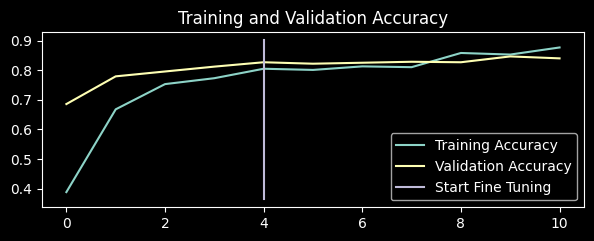

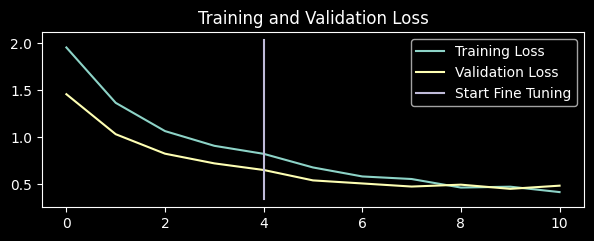

In [38]:
compare_history(history_2, history_fine_10_percent_data_aug, initial_epochs = 5)

### Model 4 : Fine-tuning an existing model all of the data

In [39]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data("10_food_classes_all_data.zip")

--2024-02-16 19:25:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.207, 74.125.195.207, 172.253.117.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  53.2MB/s    in 7.1s    

2024-02-16 19:25:32 (70.2 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [40]:
# Setup training and testing directories

train_dir = '10_food_classes_all_data/train/'
test_dir = '10_food_classes_all_data/test/'

In [41]:
# Setup Data Inputs
import tensorflow as tf

IMG_SIZE = (224, 224)

train_data_full = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                      image_size = IMG_SIZE,
                                                                      label_mode = "categorical")

test_data_full = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                     image_size = IMG_SIZE,
                                                                     label_mode = "categorical")

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


* As it is now, our model_2 has been fine-tuned on 10 percent of the data, so to begin fine-tuning on all of the data and keep our experiments consistent, we need to revert it back to the weights we checkpointed after 5 epochs of feature-extraction.

In [42]:
def create_base_model(input_shape: tuple[int, int, int] = (224, 224, 3),
                      output_shape: int = 10,
                      learning_rate: float = 0.001,
                      training: bool = False) -> tf.keras.Model:
    """
    Create a model based on EfficientNetV2B0 with built-in data augmentation.

    Parameters:
    - input_shape (tuple): Expected shape of input images. Default is (224, 224, 3).
    - output_shape (int): Number of classes for the output layer. Default is 10.
    - learning_rate (float): Learning rate for the Adam optimizer. Default is 0.001.
    - training (bool): Whether the base model is trainable. Default is False.

    Returns:
    - tf.keras.Model: The compiled model with specified input and output settings.
    """

    # Create base model
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
    base_model.trainable = training

    # Setup model input and outputs with data augmentation built-in
    inputs = layers.Input(shape=input_shape, name="input_layer")
    x = data_augmentation(inputs)
    x = base_model(x, training=False)  # pass augmented images to base model but keep it in inference mode
    x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    outputs = layers.Dense(units=output_shape, activation="softmax", name="output_layer")(x)
    model = tf.keras.Model(inputs, outputs)

    # Compile model
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    return model

# Create an instance of model_2 with our new function
model_2 = create_base_model()

In [43]:
model_2 = create_base_model(learning_rate = 0.0001)
model_2.load_weights(checkpoint_path)

In [44]:
model_2.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
                metrics = ["accuracy"])

In [45]:
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full  = model_2.fit(train_data_full,
                                         epochs = fine_tune_epochs,
                                         validation_data = test_data_full,
                                         validation_steps = int(0.25 * len(test_data_full)),
                                         initial_epoch = history_2.epoch[-1],
                                         callbacks = [create_tensorboard_callback(
                                             dir_name = "transfer_learning",
                                             experiment_name = 'full_10_classes_fine_tune_last_10')])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20240216-192548
Epoch 5/10
235/235 [==============================] - 133s 531ms/step - loss: 0.8712 - accuracy: 0.7475 - val_loss: 0.5525 - val_accuracy: 0.8421
Epoch 6/10
235/235 [==============================] - 96s 409ms/step - loss: 0.8139 - accuracy: 0.7676 - val_loss: 0.5170 - val_accuracy: 0.8503
Epoch 7/10
235/235 [==============================] - 82s 349ms/step - loss: 0.7743 - accuracy: 0.7711 - val_loss: 0.5101 - val_accuracy: 0.8405
Epoch 8/10
235/235 [==============================] - 70s 299ms/step - loss: 0.7399 - accuracy: 0.7801 - val_loss: 0.4759 - val_accuracy: 0.8421
Epoch 9/10
235/235 [==============================] - 67s 282ms/step - loss: 0.7184 - accuracy: 0.7851 - val_loss: 0.4549 - val_accuracy: 0.8470
Epoch 10/10
235/235 [==============================] - 62s 263ms/step - loss: 0.7017 - accuracy: 0.7944 - val_loss: 0.4094 - val_accuracy: 0.8701


In [46]:
results_fine_tune_full_data = model_2.evaluate(test_data)

79/79 [==============================] - 10s 108ms/step - loss: 0.4452 - accuracy: 0.8676
